In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

data = np.loadtxt('RHdata.data')
labels = np.loadtxt('RHlabel.labels')

df = pd.DataFrame(data)
df['Label'] = labels

In [2]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

In [9]:
def get_distribution_stats(data_window):
    return {
        'mean': np.mean(data_window, axis=0),
        'std': np.std(data_window, axis=0),
        'median': np.median(data_window, axis=0),
        'skewness': [np.mean((data_window[:, i] - np.mean(data_window[:, i]))**3 / 
                    (np.std(data_window[:, i])**3)) for i in range(data_window.shape[1])]
    }

window_size = 100
step_size = 50 
threshold = 0.5

windows = []
drift_scores = []

feature_cols = [col for col in df.columns if col not in ['Label', 'PCA1', 'PCA2']]

for i in range(0, len(df)-window_size+1, step_size):
    current_window = df[feature_cols].iloc[i:i+window_size].values
    stats = get_distribution_stats(current_window)
    windows.append(stats)

    if i == 0:
        base_stats = stats
        drift_score = 0
    else:
        drift_score = 0
        for feat in range(len(feature_cols)):
            drift_score += np.abs(stats['mean'][feat] - base_stats['mean'][feat])
            drift_score += np.abs(stats['std'][feat] - base_stats['std'][feat]) * 0.5
            
    drift_scores.append(drift_score)

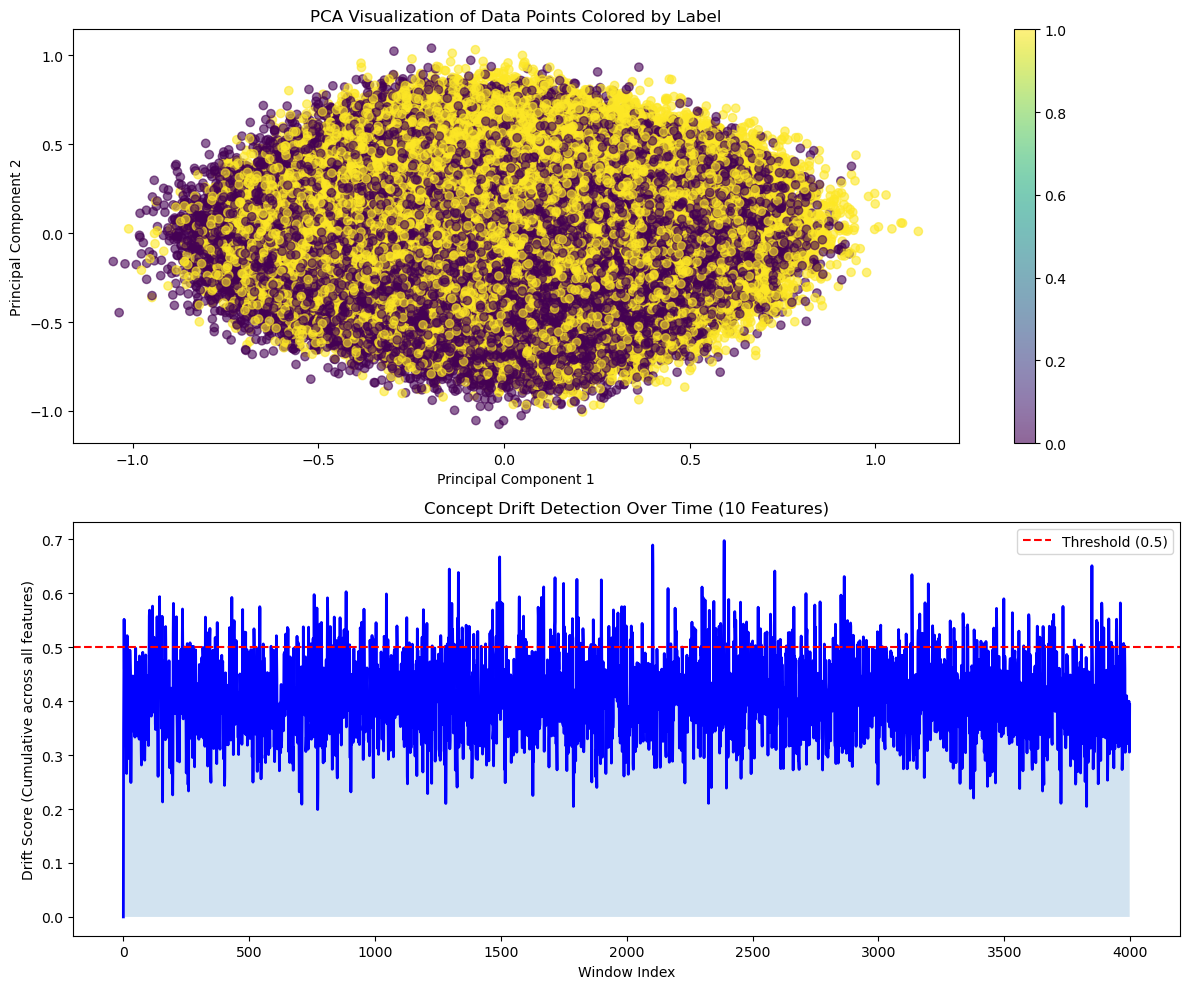

In [10]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['Label'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('PCA Visualization of Data Points Colored by Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(212)
plt.plot(range(len(drift_scores)), drift_scores, 'b-', linewidth=2)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
plt.fill_between(range(len(drift_scores)), drift_scores, alpha=0.2)
plt.title('Concept Drift Detection Over Time (10 Features)')
plt.xlabel('Window Index')
plt.ylabel('Drift Score (Cumulative across all features)')
plt.legend()

plt.tight_layout()
plt.show()